# Ions in a Flame

In this example we simulate a freely-propagating, adiabatic, 1-D flame and
* Calculate ions concentration in a flame

The figure below illustrates the setup, in a flame-fixed co-ordinate system. The reactants enter with density $\rho_{u}$, temperature $T_{u}$ and speed $S_{u}$. The products exit the flame at speed $S_{b}$, density $\rho_{b}$ and temperature $T_{b}$.

<img src="images/flameSpeed.png" alt="Freely Propagating Flame" style="width: 300px;"/>

In [1]:
from __future__ import print_function
from __future__ import division

import cantera as ct
import numpy as np

print("Running Cantera Version: " + str(ct.__version__))

Running Cantera Version: 2.4.0a1


### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [8]:
#Inlet Temperature in Kelvin and Inlet Pressure in Pascals
#In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

#Define the gas-mixutre and kinetics
#In this case, we are choosing a GRI3.0 gas
gas = ct.Solution('gri30_ion.cti')

# Create a stoichiometric CH4/Air premixed mixture 
gas.set_equivalence_ratio(1.0, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

### Define flame simulation conditions

In [9]:
# Domain width in metres
width = 0.05

# Create the flame object
flame = ct.IonFlame(gas, width=width)

# Define tolerances for the solver
flame.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)

# Define logging level
loglevel = 1

### Solve- stage #1: Frozen-Ion Method

In this stage, the diffusion of ions is turned off due to the fast diffusion rate of electron without internal electric forces (ambi-polar diffusion effect).

In [10]:
# stage one
flame.solve(loglevel=loglevel, auto=True)


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      4.665
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0005474      3.405
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0004384      4.761
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     9.753e-06      6.918
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001666      5.248
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.004271      3.491
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
grid refinement d

Attempt Newton solution of steady-state problem...    success.

Problem solved on [188] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 95 
    to resolve C2H3 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [189] point grid(s).

..............................................................................
no new points needed in flame


### Solve- stage #2: Charge-Neutrality Model

The second stage uses charge neutrality model, which assume zero charge flux throughout the domain, to calculate drift flux. The drift flux is added to the total flux of ions.

In [11]:
# stage two
flame.solve(loglevel=loglevel, stage=2, enable_energy=False)
flame.solve(loglevel=loglevel, stage=2, enable_energy=True)


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.746e-06      2.176
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.604e-05      1.594
Attempt Newton solution of steady-state problem...    success.

Problem solved on [189] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 22 184 185 186 
    to resolve H2O2 NO NO2 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [193] point grid(s).

.......................................................................

### Solve- stage #3: Poisson Equation Method

The third stage evaluates drift flux from electric field calculated from Poisson's equation, which is solved together with other equations. Poisson's equation is coupled because the total charge densities depends on the species' concentration.

In [12]:
# stage three
flame.solve(loglevel=loglevel, stage=3, enable_energy=True)


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.335e-06      3.274
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.811e-06      2.974
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.312e-05      2.492
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.000395      1.451
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.006749    -0.6517
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps        0.3892     -4.696
Attempt Newton solution of steady-state problem...    success.

Problem solved on [194] point grid(s).

..............................................................................
##############################################################################
Refining grid in

### Plot figures

Check and see if all has gone well. Plot temperature and species fractions to see

In [13]:
# Import plotting modules and define plotting preference
import matplotlib.pylab as plt
%matplotlib notebook

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (8,6)

# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')

plt.rcParams['figure.autolayout'] = True

#### Temperature Plot

<IPython.core.display.Javascript object>


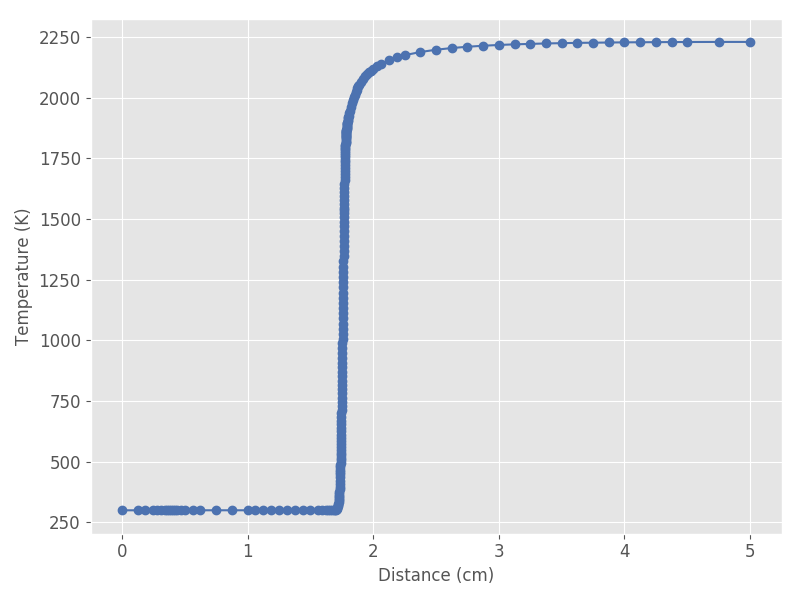

In [14]:
plt.figure()

plt.plot(flame.grid*100, flame.T, '-o')
plt.xlabel('Distance (cm)')
plt.ylabel('Temperature (K)');

#### Electric Potential Plot

<IPython.core.display.Javascript object>


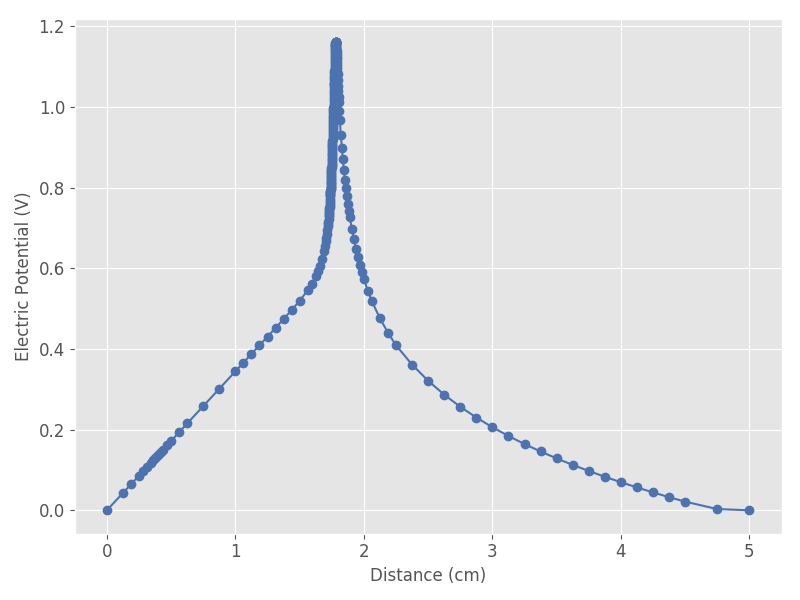

In [15]:
plt.figure()
plt.plot(flame.grid*100, flame.phi, '-o')
plt.xlabel('Distance (cm)')
plt.ylabel('Electric Potential (V)');

#### Electric Field Plot

<IPython.core.display.Javascript object>


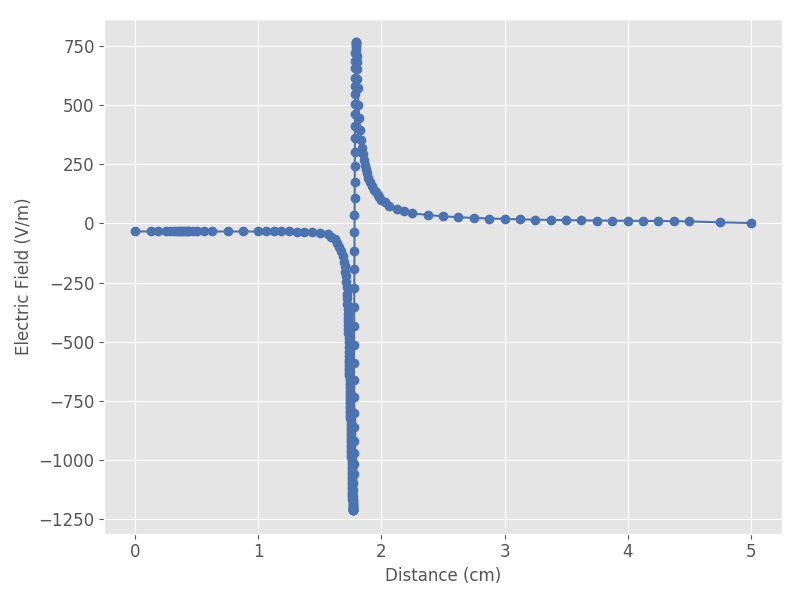

In [16]:
plt.figure()
plt.plot(flame.grid*100, flame.E, '-o')
plt.xlabel('Distance (cm)')
plt.ylabel('Electric Field (V/m)');

#### Charged species' plot

<IPython.core.display.Javascript object>


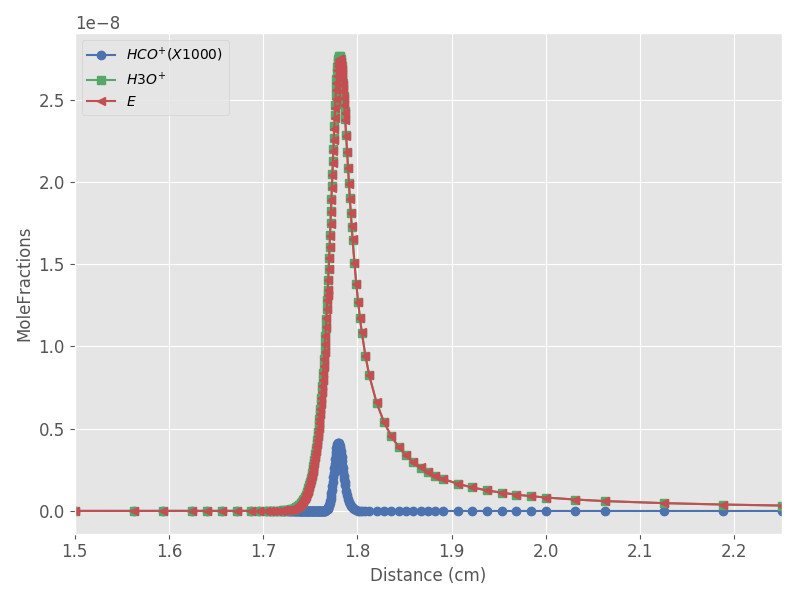

In [21]:
"""
# To plot species, we first have to identify the index of the species in the array
# For this, cut & paste the following lines and run in a new cell to get the index
for i, specie in enumerate(gas.species()):
    print(str(i) + '. ' + str(specie))
"""

# Extract concentration data
X_HCOp = flame.X[53]
X_H3Op = flame.X[54]
X_E = flame.X[55]

plt.figure()

plt.plot(flame.grid*100, X_HCOp*1000, '-o', label=r'$HCO^{+}(X{1000})$')
plt.plot(flame.grid*100, X_H3Op, '-s', label=r'$H3O^{+}$')
plt.plot(flame.grid*100, X_E, '-<', label=r'$E$')

plt.legend(loc=2)
plt.xlim([1.5,2.25])
plt.xlabel('Distance (cm)')
plt.ylabel('MoleFractions');